### Original Implementation using PennyLane

In [ ]:
%%capture
!pip install pennylane

In [2]:
import numpy as np
import cvxpy as cp
import scipy as sc
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable

(<Figure size 2800x1200 with 1 Axes>, <Axes: >)

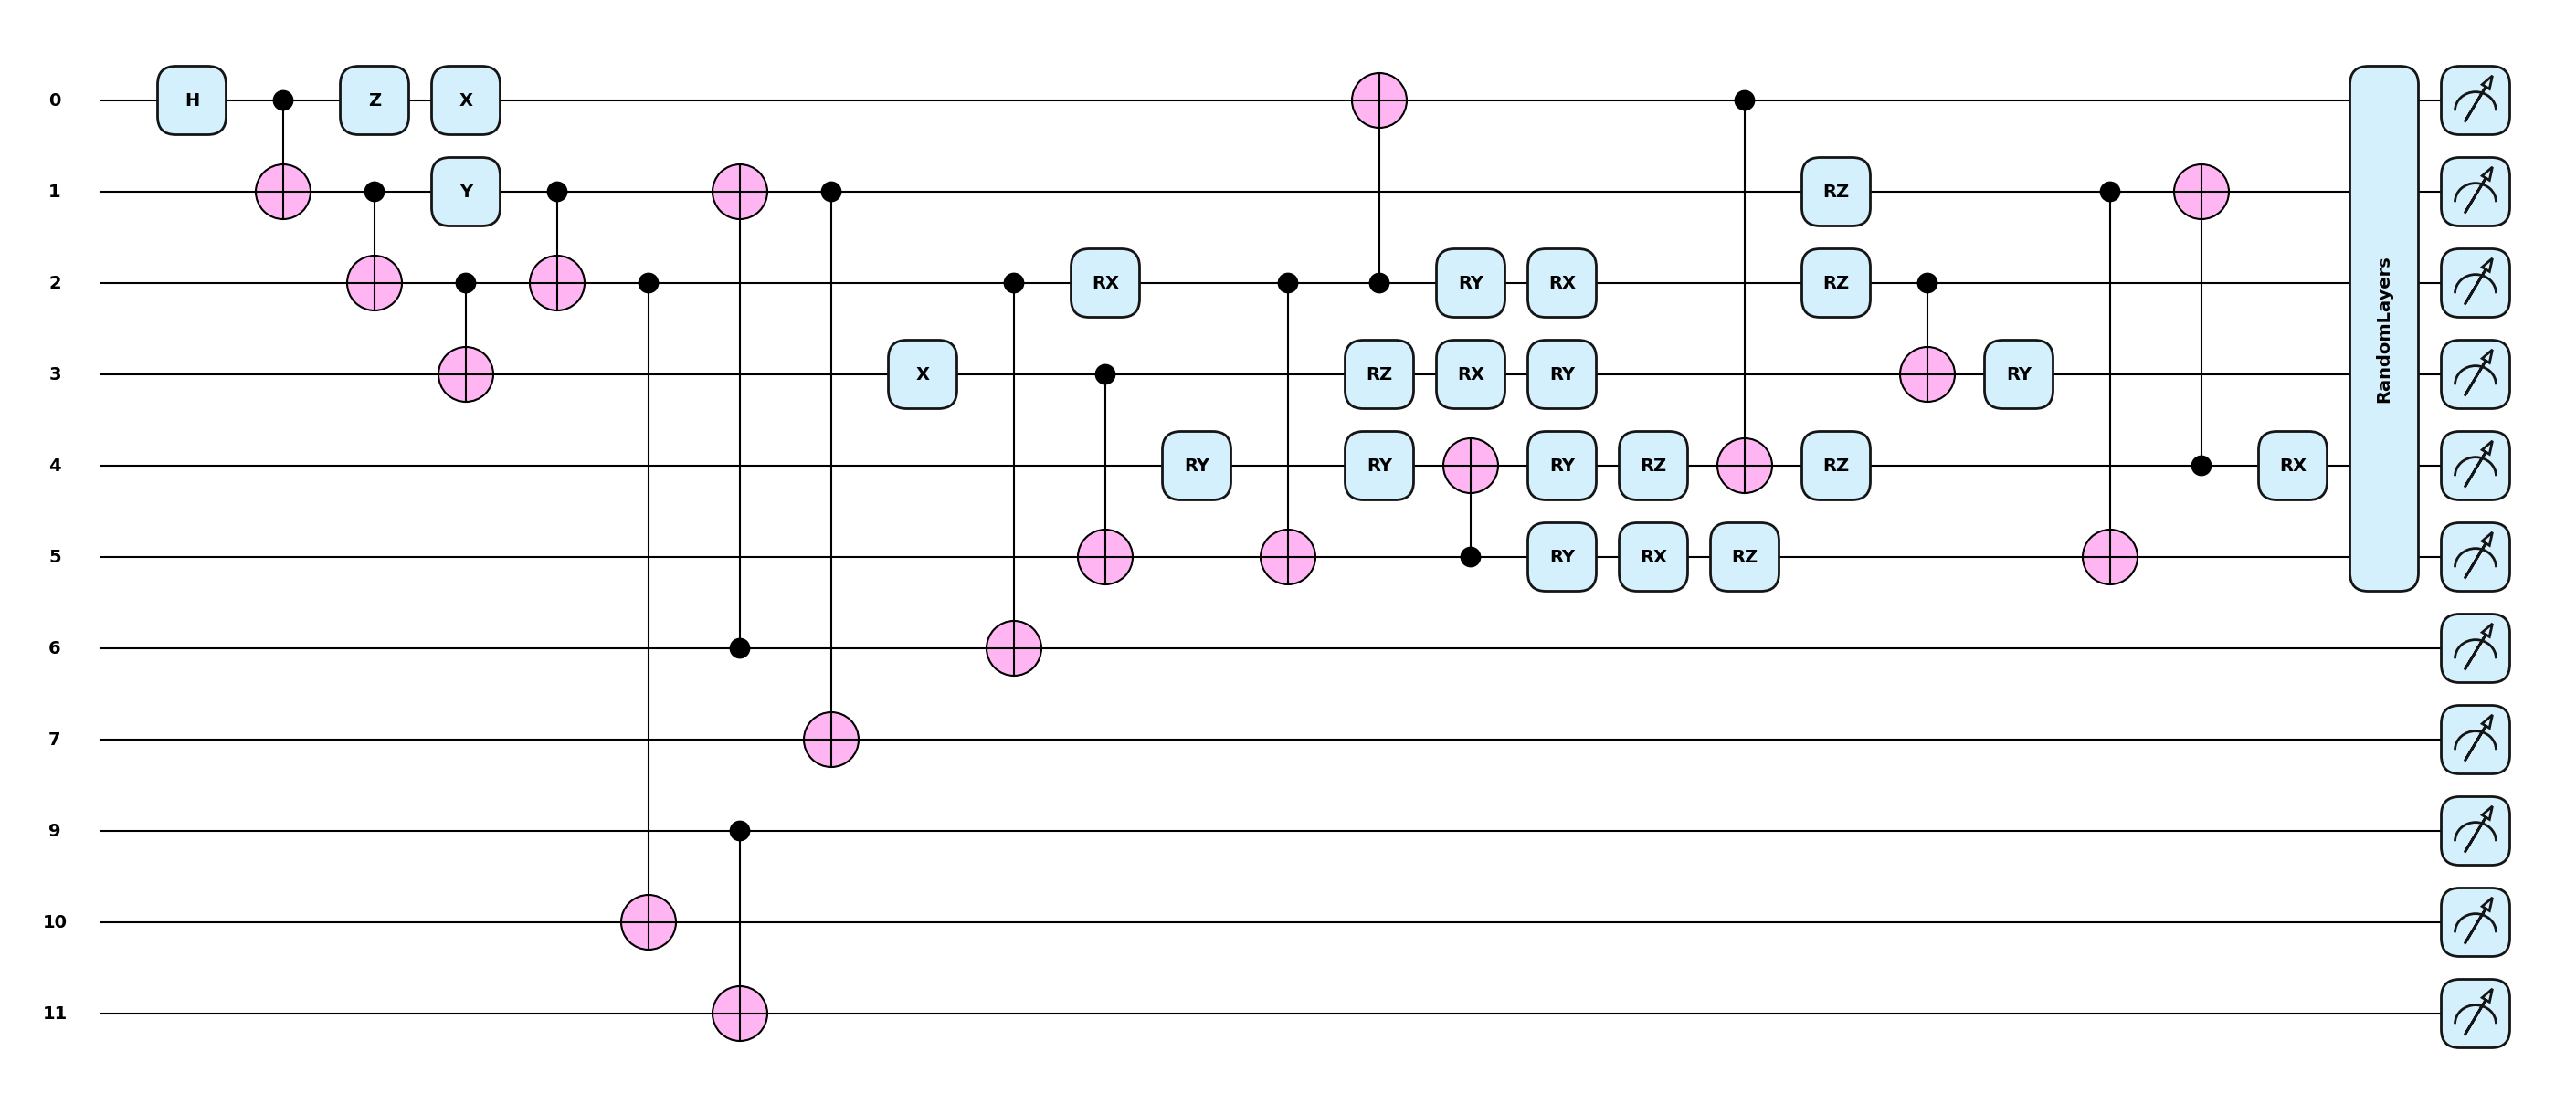

In [5]:
# quantum circuit settings
num_wires = 12
num_of_sys_qubits = num_wires/2
num_layers = 3
num_shots = 1
num_of_samples = 100

# dimension of the system
N = 64

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

# 量子回路の定義
@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 10])
    qml.CNOT(wires=[9, 11])
    qml.CNOT(wires=[6, 1])
    qml.CNOT(wires=[1, 7])
    qml.PauliX(wires=3)
    qml.CNOT(wires=[2, 6])
    qml.CNOT(wires=[3, 5])
    qml.RY(param[0][0], wires=2)
    qml.RX(param[0][1], wires=4)
    qml.CNOT(wires=[2, 5])
    qml.RZ(param[0][2], wires=3)
    qml.RX(param[1][0], wires=3)
    qml.RY(param[1][1], wires=4)
    qml.RY(param[1][2], wires=3)
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[5, 4])
    qml.RY(param[2][0], wires=4)
    qml.RY(param[2][1], wires=2)
    qml.RZ(param[2][2], wires=4)
    qml.RX(param[3][0], wires=2)
    qml.CNOT(wires=[0, 4])
    qml.RY(param[3][1], wires=5)
    qml.RZ(param[3][2], wires=2)
    qml.RZ(param[4][0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RX(param[4][1], wires=5)
    qml.RY(param[4][2], wires=3)
    qml.RZ(param[5][0], wires=4)
    qml.RZ(param[5][1], wires=5)
    qml.CNOT(wires=[1, 5])
    qml.CNOT(wires=[4, 1])
    qml.RX(param[5][2], wires=4)
    

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=np.arange(6))
    
    return qml.state()

# パラメータの定義
param = np.random.rand(3, 6)

# 回路の描画
qml.drawer.use_style("pennylane")
qml.draw_mpl(measure_rho)(param)

In [ ]:
# quantum circuit settings
num_wires = 12
num_of_sys_qubits = num_wires/2
num_layers = 3
num_shots = 1
num_of_samples = 100

# dimension of the system
N = 64

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 10])
    qml.CNOT(wires=[9, 11])
    qml.CNOT(wires=[6, 1])
    qml.CNOT(wires=[1, 7])
    qml.PauliX(wires=3)
    qml.CNOT(wires=[2, 6])
    qml.CNOT(wires=[3, 5])

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=np.arange(6))

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)), qml.sample(qml.PauliZ(2)), qml.sample(qml.PauliZ(3)), qml.sample(qml.PauliZ(4)), qml.sample(qml.PauliZ(5))
    return result

# maximally mixed state
sigma = np.eye(N)/N

In [ ]:
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
rho_test = measure_rho_no_nn_samples(param_init)

In [ ]:
# Evaluate von Neumann entropy using its analytical forumla

# ignore the division by zero
np.seterr(divide = 'ignore')

# quantum relative entropy
H_rho = np.real(np.trace(rho_test @ (sc.linalg.logm(rho_test) - sc.linalg.logm(sigma))))

np.seterr(divide = 'warn')

# print the result
print(np.log(N)-H_rho)

In [ ]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [ ]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 3000
learning_rate = 0.05
num_of_samples = 100
dimension = int(num_wires/2)
hidden_layer = 2

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=int(num_wires/2))
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=int(num_wires/2))
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(np.log(N) - first_term + second_term - 1)

In [ ]:
def binary_array_to_decimal(arr):
    # Replace -1 with 0
    arr = np.where(arr == -1, 0, arr)
    # Convert the array to a binary string
    binary_string = ''.join(str(i) for i in arr)
    # Convert the binary string to a decimal value
    decimal_value = int(binary_string, 2)
    return decimal_value

In [ ]:
result = measure_rho_no_nn_samples(prev_param_init)
sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
print(binary_array_to_decimal(sample_result_array))
print(sample_result_array)

In [ ]:
#@title Optimization using Gradient Descent (without neural network)

# parameters of the optimization
num_of_epochs = 3000
learning_rate = 0.08
num_of_samples = 100
deviation = 1
seed_no=42

# initialize the neural network and quantum circuit parameters
W = deviation*np.random.rand(64)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []


# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho_no_nn_samples(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
                forward_sum += W[binary_array_to_decimal(sample_result_array)]

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho_no_nn_samples(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
                backward_sum += W[binary_array_to_decimal(sample_result_array)]

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the eigenvalues

    dW = np.zeros(64)
    result = measure_rho_no_nn_samples(prev_param_init)
    for i in range(64):
        E = np.zeros(64)
        E[i] = 1
        for sample in range(num_of_samples):
            sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
            dW[i] -= E[binary_array_to_decimal(sample_result_array)]
        dW[i] = dW[i]/num_of_samples
        dW[i] += np.exp(W[i])/N 
#     probs = measure_rho_no_nn_probs(prev_param_init)
#     for i in range(64):
#         dW[i] = np.exp(W[i])/N - probs[i]
    
    W -= learning_rate*dW

    # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho_no_nn_samples(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
        first_term += W[binary_array_to_decimal(sample_result_array)]

    # normalize the cost sum
    first_term = first_term/num_of_samples

    second_term = np.sum(np.exp(W))

  # normalize the second term sum
    second_term = second_term/N

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

    # print the cost
    print(np.log(N) - first_term + second_term - 1)

In [ ]:
E = np.zeros_like(W)
num_of_samples = 100
E[58] = 1
dW1 = 0
result = measure_rho_no_nn_samples(prev_param_init)
for sample in range(num_of_samples):
    sample_result_array = np.array([result[i][sample] for i in range(int(num_wires/2))])
    dW1 -= E[binary_array_to_decimal(sample_result_array)]
probs = measure_rho_no_nn_probs(prev_param_init)
print(dW1/num_of_samples, probs[58])

In [ ]:
print(probs)

### Qiskit Implementation

In [ ]:
%%capture
%matplotlib inline

!pip install qiskit qiskit-aer pylatexenc pandas

In [1]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit import Parameter
from qiskit.quantum_info import random_unitary
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
num_wires = 12
num_of_sys_qubits = num_wires/2
num_layers = 3
num_rotations = 3
num_shots = 1
num_of_samples = 100

# dimension of the system
N = 64

# initiate the quantum device
simulator = AerSimulator(method='statevector')

qc = QuantumCircuit(num_wires)

param = np.random.random((num_layers, num_rotations))

parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]
param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.z(0)
qc.x(0)
qc.y(1)
qc.cx(1, 2)
qc.cx(2, 10)
qc.cx(9, 11)
qc.cx(6, 1)
qc.cx(1, 7)
qc.x(3)
qc.cx(2, 6)
qc.cx(3, 5)
qc.ry(parameters[0][0], 2)
qc.rx(parameters[0][1], 4)
qc.cx(2, 5)
qc.rz(parameters[0][2], 3)
qc.rx(parameters[1][0], 3)
qc.ry(parameters[1][1], 4)
qc.ry(parameters[1][2], 3)
qc.cx(2, 0)
qc.cx(5, 4)
qc.ry(parameters[2][0], 4)
qc.ry(parameters[2][1], 2)
qc.rz(parameters[2][2], 4)
qc.rx(parameters[3][0], 2)
qc.cx(0, 4)
qc.ry(parameters[3][1], 5)
qc.rz(parameters[3][2], 2)
qc.rz(parameters[4][0], 1)
qc.cx(2, 3)
qc.rx(parameters[4][1], 5)
qc.ry(parameters[4][2], 3)
qc.rz(parameters[5][0], 4)
qc.rz(parameters[5][1], 5)
qc.cx(1, 5)
qc.cx(4, 1)
qc.rx(parameters[5][2], 4)

qc.asign_parameters(param_dict)
qc.draw(output='mpl')


In [ ]:
def measure_rho(param):
    num_wires = 12
    num_of_sys_qubits = num_wires/2
    num_layers = 3
    num_rotations = 3
    num_shots = 1
    num_of_samples = 100

    # dimension of the system
    N = 64

    # initiate the quantum device
    simulator = AerSimulator(method='statevector')

    qc = QuantumCircuit(num_wires)

    parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]
    param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}

    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)
    qc.cx(1, 2)
    qc.cx(2, 10)
    qc.cx(9, 11)
    qc.cx(6, 1)
    qc.cx(1, 7)
    qc.x(3)
    qc.cx(2, 6)
    qc.cx(3, 5)
    qc.ry(parameters[0][0], 2)
    qc.rx(parameters[0][1], 4)
    qc.cx(2, 5)
    qc.rz(parameters[0][2], 3)
    qc.rx(parameters[1][0], 3)
    qc.ry(parameters[1][1], 4)
    qc.ry(parameters[1][2], 3)
    qc.cx(2, 0)
    qc.cx(5, 4)
    qc.ry(parameters[2][0], 4)
    qc.ry(parameters[2][1], 2)
    qc.rz(parameters[2][2], 4)
    qc.rx(parameters[3][0], 2)
    qc.cx(0, 4)
    qc.ry(parameters[3][1], 5)
    qc.rz(parameters[3][2], 2)
    qc.rz(parameters[4][0], 1)
    qc.cx(2, 3)
    qc.rx(parameters[4][1], 5)
    qc.ry(parameters[4][2], 3)
    qc.rz(parameters[5][0], 4)
    qc.rz(parameters[5][1], 5)
    qc.cx(1, 5)
    qc.cx(4, 1)
    qc.rx(parameters[5][2], 4)    

    qc.asign_parameters(param_dict)

    qc.save_statevector()

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    statevector = result.get_statevector()

    density_matrix = DensityMatrix(statevector)
    rho = partial_trace(density_matrix, [0, 1])
    return np.array(rho)

In [ ]:
def measure_bitstring(param):
    num_wires = 12
    num_of_sys_qubits = num_wires/2
    num_layers = 3
    num_rotations = 3
    num_shots = 1
    num_of_samples = 100

    # dimension of the system
    N = 64

    # initiate the quantum device
    simulator = AerSimulator(method='statevector')

    qc = QuantumCircuit(num_wires)

    parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]
    param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}

    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)
    qc.cx(1, 2)
    qc.cx(2, 10)
    qc.cx(9, 11)
    qc.cx(6, 1)
    qc.cx(1, 7)
    qc.x(3)
    qc.cx(2, 6)
    qc.cx(3, 5)
    qc.ry(parameters[0][0], 2)
    qc.rx(parameters[0][1], 4)
    qc.cx(2, 5)
    qc.rz(parameters[0][2], 3)
    qc.rx(parameters[1][0], 3)
    qc.ry(parameters[1][1], 4)
    qc.ry(parameters[1][2], 3)
    qc.cx(2, 0)
    qc.cx(5, 4)
    qc.ry(parameters[2][0], 4)
    qc.ry(parameters[2][1], 2)
    qc.rz(parameters[2][2], 4)
    qc.rx(parameters[3][0], 2)
    qc.cx(0, 4)
    qc.ry(parameters[3][1], 5)
    qc.rz(parameters[3][2], 2)
    qc.rz(parameters[4][0], 1)
    qc.cx(2, 3)
    qc.rx(parameters[4][1], 5)
    qc.ry(parameters[4][2], 3)
    qc.rz(parameters[5][0], 4)
    qc.rz(parameters[5][1], 5)
    qc.cx(1, 5)
    qc.cx(4, 1)
    qc.rx(parameters[5][2], 4)    

    qc.asign_parameters(param_dict)
    qc.measure_all()

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_of_samples)
    result = job.result()
    counts = result.get_counts()

    z0_samples = []
    z1_samples = []
    z2_samples = []
    z3_samples = []
    z4_samples = []
    z5_samples = []
    
    for bitstring, count in count.items():
        z0 = int(bitstring[-1])
        z1 = int(bitstring[-2])
        z2 = int(bitstring[-3])
        z3 = int(bitstring[-4])
        z4 = int(bitstring[-5])
        z5 = int(bitstring[-6])

        z0_samples.extend([z0]*count)
        z1_samples.extend([z1]*count)
        z2_samples.extend([z2]*count)
        z3_samples.extend([z3]*count)
        z4_samples.extend([z4]*count)
        z5_samples.extend([z5]*count)

    return z0_samples, z1_samples, z2_samples, z3_samples, z4_samples, z5_samples